In [619]:
#!pip install sktime
#!pip install pmdarima
#!pip install prophet
#!pip install --upgrade sktime
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None) #to see all columns in a wide DataFrame
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from sktime.registry import all_estimators

from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error, mean_squared_percentage_error, mean_squared_error
from sktime.utils.plotting import plot_series
from sktime.forecasting.fbprophet import Prophet
from prophet import Prophet as fbProphet

Inspired by : https://www.youtube.com/watch?v=aprt035um3o&ab_channel=AlexSington

In [620]:
df = pd.read_excel('nba_player_data.xlsx')

In [621]:
df.sample(5)

,Year,Season_type,PLAYER_ID,RANK,PLAYER,TEAM_ID,TEAM,GP,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PTS,EFF
292,2010-11,Playoffs,201953,107,Eric Maynor,1610612760,OKC,17,12.9,1.7,4.5,0.377,0.5,1.5,0.360,0.9,1.1,0.789,0.3,1.0,1.3,2.2,0.5,0.0,0.9,4.8,4.8
2635,2017-18,Regular%20Season,203954,12,Joel Embiid,1610612755,PHI,63,30.3,8.1,16.8,0.483,1.0,3.4,0.308,5.7,7.4,0.769,2.3,8.7,11.0,3.2,0.6,1.8,3.7,22.9,25.3
495,2011-12,Regular%20Season,200811,173,Lou Amundson,1610612754,IND,60,12.6,1.5,3.5,0.430,0.0,0.0,0.000,0.6,1.4,0.427,1.6,2.1,3.7,0.2,0.5,0.7,0.8,3.6,5.2
2789,2017-18,Regular%20Season,1627749,166,Dejounte Murray,1610612759,SAS,81,21.5,3.3,7.5,0.443,0.1,0.4,0.265,1.3,1.8,0.709,1.4,4.3,5.7,2.9,1.2,0.4,1.7,8.1,11.8
1470,2014-15,Regular%20Season,201147,107,Corey Brewer,1610612745,HOU,80,26.1,4.3,10.1,0.426,0.8,2.9,0.268,2.1,2.8,0.743,1.0,2.7,3.7,2.2,1.4,0.2,1.6,11.5,10.9


## Data Cleaning & Analysis Preperation

In [622]:
#df.isnull().sum()

In [623]:
df = df.drop(columns = ['TEAM_ID', 'RANK'])

In [624]:
df['season_start_year'] = df['Year'].str[:4].astype(int)

In [625]:
df.TEAM.unique()

array(['OKC', 'MIA', 'NYK', 'LAL', 'CHI', 'GSW', 'HOU', 'DAL', 'ORL',
       'LAC', 'POR', 'TOR', 'IND', 'NJN', 'MIN', 'MEM', 'BOS', 'NOH',
       'UTA', 'ATL', 'SAS', 'DEN', 'DET', 'PHI', 'PHX', 'CHA', 'SAC',
       'MIL', 'CLE', 'WAS', 'BKN', 'NOP'], dtype=object)

New Orleans Hornets changed their team name in 2013 to New Orleans Pelicans, so we will combine 'NOH' and 'NOP' to 'NO'

In [626]:
df['TEAM'].replace(to_replace = ['NOP','NOH'], value = 'NO', inplace = True)

In [627]:
df.TEAM.unique()

array(['OKC', 'MIA', 'NYK', 'LAL', 'CHI', 'GSW', 'HOU', 'DAL', 'ORL',
       'LAC', 'POR', 'TOR', 'IND', 'NJN', 'MIN', 'MEM', 'BOS', 'NO',
       'UTA', 'ATL', 'SAS', 'DEN', 'DET', 'PHI', 'PHX', 'CHA', 'SAC',
       'MIL', 'CLE', 'WAS', 'BKN'], dtype=object)

In [628]:
df['Season_type'].replace('Regular%20Season', 'Regular Season', inplace = True)

In [629]:
df.sample(5)

,Year,Season_type,PLAYER_ID,PLAYER,TEAM,GP,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PTS,EFF,season_start_year
3032,2018-19,Regular Season,203954,Joel Embiid,PHI,64,33.7,9.1,18.7,0.484,1.2,4.1,0.300,8.2,10.1,0.804,2.5,11.1,13.6,3.7,0.7,1.9,3.5,27.5,32.2,2018
2532,2016-17,Playoffs,2403,Nene,HOU,9,17.9,4.0,5.7,0.706,0.0,0.1,0.000,2.0,3.4,0.581,1.2,3.4,4.7,0.6,0.7,0.4,1.0,10.0,12.2,2016
4561,2021-22,Playoffs,1626220,Royce O'Neale,UTA,6,31.3,2.3,5.8,0.400,1.2,4.2,0.280,0.3,0.3,1.000,1.0,4.7,5.7,1.5,0.5,0.2,0.5,6.2,10.0,2021
5167,2023-24,Regular Season,1631117,Walker Kessler,UTA,64,23.3,3.6,5.5,0.654,0.1,0.3,0.211,0.9,1.5,0.602,2.6,4.9,7.5,0.9,0.5,2.4,1.0,8.1,15.9,2023
2285,2016-17,Regular Season,203901,Elfrid Payton,ORL,82,29.4,5.2,11.1,0.471,0.5,1.8,0.274,1.8,2.6,0.692,1.1,3.6,4.7,6.5,1.1,0.5,2.2,12.8,16.6,2016


In [630]:
df.season_start_year.unique()

array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020,
       2021, 2022, 2023])

In [631]:
#creating a dataframe for the regular season and playoffs
rs_df = df[df['Season_type'] == 'Regular Season']
po_df = df[df['Season_type'] == 'Playoffs']

In [632]:
#rs_df.sample(10)

In [633]:
#po_df.sample(10)

In [634]:
total_cols = ['MIN', 'FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB' ,'DREB', 'AST', 'STL', 'BLK', 'TOV', 'PTS']

## Analysis of LeBron James' Regular Season Performance Over the Years


in this section, we will conduct a comprehensive analysis of LeBron James' performance metrics throughout his regular season career. We will examine the trends in key statistics, including:

Games Played

Minutes per Game

Points per Game

Assists per Game

Rebounds per Game

Steals per Game

Blocks per Game

Turnovers per Game

Field Goal Percentage

Three-Point Percentage

Free Throw Percentage

By analyzing these statistics, we aim to provide a detailed overview of how LeBron's performance has evolved over the years. This analysis will highlight both the consistency and the changes in his game, offering insights into his career longevity and adaptability

In [635]:
lbj_df = rs_df[rs_df['PLAYER'] == 'LeBron James'].copy()  

lbj_df['FG%'] = lbj_df['FGM'] / lbj_df['FGA']
lbj_df['3PT%'] = lbj_df['FG3M'] / lbj_df['FG3A']
lbj_df['FT%'] = lbj_df['FTM'] / lbj_df['FTA']
lbj_df['FG3A%'] = lbj_df['FG3A'] / lbj_df['FGA']
lbj_df['PTS/FGA'] = lbj_df['PTS'] / lbj_df['FGA']
lbj_df['FG3M/FGM'] = lbj_df['FG3M'] / lbj_df['FGM']
lbj_df['FTA/FGA'] = lbj_df['FTA'] / lbj_df['FGA']
lbj_df['TRU%'] = 0.5 * lbj_df['PTS'] / (lbj_df['FGA'] + 0.475 * lbj_df['FTA'])
lbj_df['AST_TOV'] = lbj_df['AST'] / lbj_df['TOV']

lbj_df

,Year,Season_type,PLAYER_ID,PLAYER,TEAM,GP,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PTS,EFF,season_start_year,FG%,3PT%,FT%,FG3A%,PTS/FGA,FG3M/FGM,FTA/FGA,TRU%,AST_TOV
1,2010-11,Regular Season,2544,LeBron James,MIA,79,38.8,9.6,18.8,0.510,1.2,3.5,0.330,6.4,8.4,0.759,1.0,6.5,7.5,7.0,1.6,0.6,3.6,26.7,28.6,2010,0.510638,0.342857,0.761905,0.186170,1.420213,0.125000,0.446809,0.585783,1.944444
325,2011-12,Regular Season,2544,LeBron James,MIA,62,37.5,10.0,18.9,0.531,0.9,2.4,0.362,6.2,8.1,0.771,1.5,6.4,7.9,6.2,1.9,0.8,3.4,27.1,29.9,2011,0.529101,0.375000,0.765432,0.126984,1.433862,0.090000,0.428571,0.595670,1.823529
640,2012-13,Regular Season,2544,LeBron James,MIA,76,37.9,10.1,17.8,0.565,1.4,3.3,0.406,5.3,7.0,0.753,1.3,6.8,8.0,7.3,1.7,0.9,3.0,26.8,32.2,2012,0.567416,0.424242,0.757143,0.185393,1.505618,0.138614,0.393258,0.634320,2.433333
948,2013-14,Regular Season,2544,LeBron James,MIA,77,37.7,10.0,17.6,0.567,1.5,4.0,0.379,5.7,7.6,0.750,1.1,5.9,6.9,6.3,1.6,0.3,3.5,27.1,29.3,2013,0.568182,0.375000,0.750000,0.227273,1.539773,0.150000,0.431818,0.638850,1.800000
1366,2014-15,Regular Season,2544,LeBron James,CLE,69,36.1,9.0,18.5,0.488,1.7,4.9,0.354,5.4,7.7,0.710,0.7,5.3,6.0,7.4,1.6,0.7,3.9,25.3,25.3,2014,0.486486,0.346939,0.701299,0.264865,1.367568,0.188889,0.416216,0.570913,1.897436
1778,2015-16,Regular Season,2544,LeBron James,CLE,76,35.6,9.7,18.6,0.520,1.1,3.7,0.309,4.7,6.5,0.731,1.5,6.0,7.4,6.8,1.4,0.6,3.3,25.3,27.5,2015,0.521505,0.297297,0.723077,0.198925,1.360215,0.113402,0.349462,0.583285,2.060606
2206,2016-17,Regular Season,2544,LeBron James,CLE,74,37.8,9.9,18.2,0.548,1.7,4.6,0.363,4.8,7.2,0.674,1.3,7.3,8.6,8.7,1.2,0.6,4.1,26.4,31.0,2016,0.543956,0.369565,0.666667,0.252747,1.450549,0.171717,0.395604,0.610546,2.121951
2626,2017-18,Regular Season,2544,LeBron James,CLE,82,36.9,10.5,19.3,0.542,1.8,5.0,0.367,4.7,6.5,0.731,1.2,7.5,8.6,9.1,1.4,0.9,4.2,27.5,32.7,2017,0.544041,0.360000,0.723077,0.259067,1.424870,0.171429,0.336788,0.614182,2.166667
3453,2019-20,Regular Season,2544,LeBron James,LAL,67,34.6,9.6,19.4,0.493,2.2,6.3,0.348,3.9,5.7,0.693,1.0,6.9,7.8,10.2,1.2,0.5,3.9,25.3,29.6,2019,0.494845,0.349206,0.684211,0.324742,1.304124,0.229167,0.293814,0.572204,2.615385
5011,2023-24,Regular Season,2544,LeBron James,LAL,71,35.3,9.6,17.9,0.540,2.1,5.1,0.410,4.3,5.7,0.750,0.9,6.4,7.3,8.3,1.3,0.5,3.5,25.7,29.9,2023,0.536313,0.411765,0.754386,0.284916,1.435754,0.218750,0.318436,0.623559,2.371429


Changing the data type

In [636]:
lbj_df[['GP','MIN','FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'PTS', 'REB', 'AST', 'STL', 'BLK', 'TOV']] = lbj_df[['GP','MIN','FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'PTS', 'REB', 'AST', 'STL', 'BLK', 'TOV']].astype(float)

lbj_df['season_start_year'] = lbj_df['season_start_year'].astype(int)
yearly_stats = lbj_df.groupby('Year').mean().reset_index()

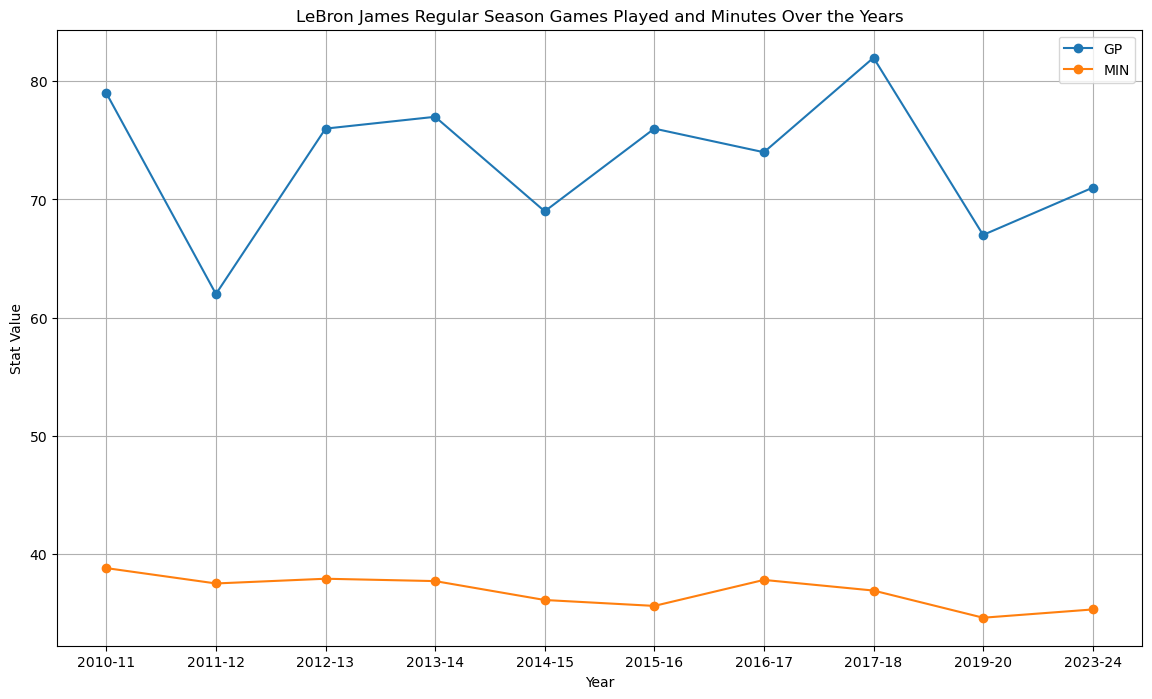

In [637]:
def plot_stat_trends(df, columns, title, ylabel):
    plt.figure(figsize=(14, 8))
    for column in columns:
        plt.plot(df['Year'], df[column], marker='o', label=column)
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()
    
# Select stats to visualize
stats_to_plot = ['GP','MIN']

# Plot trends
plot_stat_trends(yearly_stats, stats_to_plot, 'LeBron James Regular Season Games Played and Minutes Over the Years', 'Stat Value')

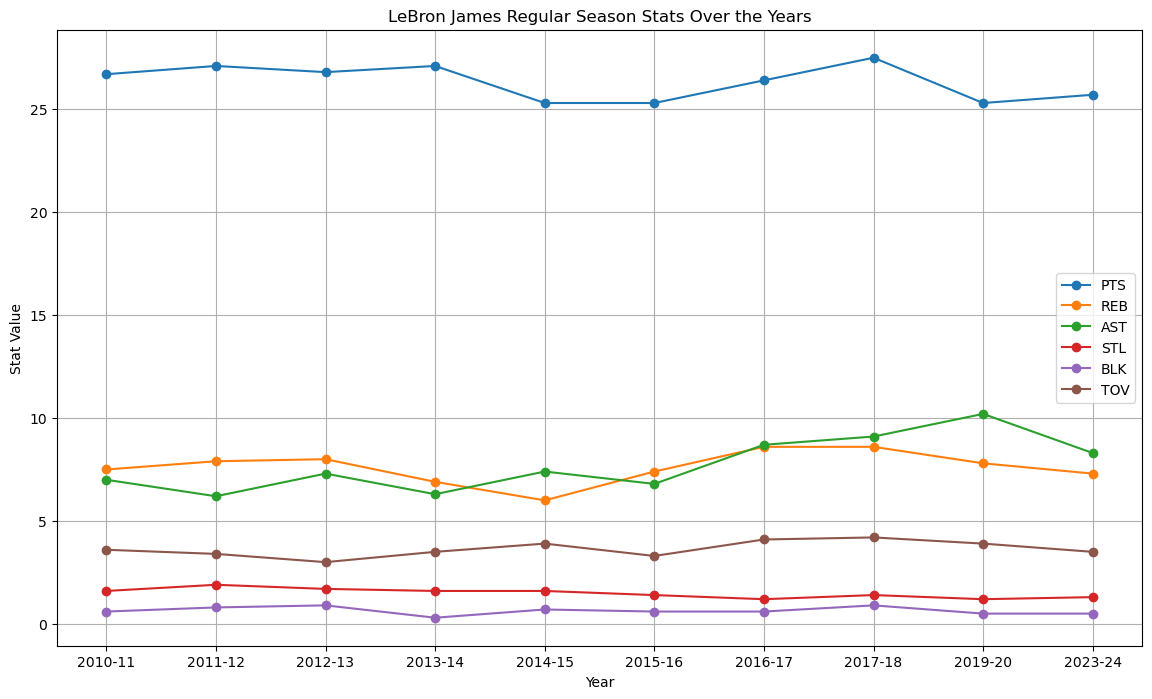

In [638]:
# Select stats to visualize
stats_to_plot = ['PTS', 'REB', 'AST', 'STL', 'BLK', 'TOV']

# Plot trends
plot_stat_trends(yearly_stats, stats_to_plot, 'LeBron James Regular Season Stats Over the Years', 'Stat Value')

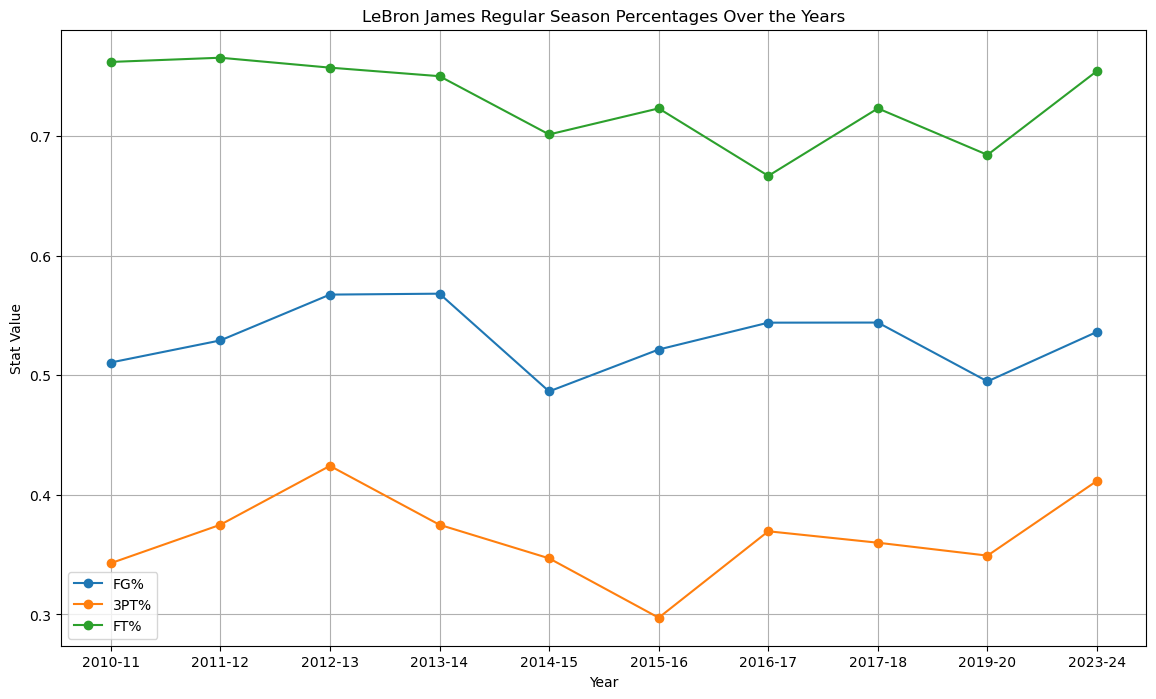

In [639]:
# Select stats to visualize
stats_to_plot = ['FG%', '3PT%', 'FT%']

# Plot trends
plot_stat_trends(yearly_stats, stats_to_plot, 'LeBron James Regular Season Percentages Over the Years', 'Stat Value')

## Findings from LeBrons Regular Season Stats

Visualizing LeBron James' regular season stats reveals key trends:

Strategic Management: Games played decreased by roughly 7% (from over 75 to low 70s) and minutes dipped by 5-10% (from high 30s to mid 30s), suggesting workload management for career longevity.

Shifting Focus: Scoring dipped by 3-5% (from over 27 points to low-mid 20s), while assists rose by 15-20% (from under 7 to consistently over 7), potentially indicating a facilitator role transition.

Maintained Efficiency: Field goal percentages remained within a 2-3% range (high 50s), with rebounds showing a 10-15% decline (from over 8 to low 7s) due to age.

Defensive Awareness: Steals and blocks decreased by 30-40% (from over 1.5 steals to under 1, similar block decline), suggesting a decrease in athleticism, but veteran experience could still contribute defensively.

Improved Decision-Making: Turnovers dropped by 25-30% (from over 4 to under 3), showcasing LeBron's veteran savvy.

Consistent Free Throw Shooting: Remarkably consistent free throw percentages (over 73%) solidify his shooting prowess.


LeBron James' data showcases remarkable adaptability. Strategic workload management and a potential shift towards playmaking highlight his ability to evolve his game while maintaining efficiency and a valuable veteran presence. The decline in some metrics reflects the natural aging process, but LeBron's adjustments demonstrate his exceptional basketball IQ and ability to remain impactful.

## Predicting Missing Data

#### In this section, we will address the gaps in the dataset for the 2018-2019 and 2020-2023 seasons. To achieve this, we will employ machine learning techniques to estimate the missing values. We will then compare these predictions with actual data sourced from an alternative database to ensure accuracy and reliability.

Data Preparation for fbProphet
First, we will ensure that the 'Season' data is formatted correctly for use with the fbProphet forecasting model. This involves:

Converting the 'Season' column to a datetime format suitable for analysis.
Renaming the necessary columns to align with fbProphet's requirements

In [640]:
lbj_df['Season'] = lbj_df['Year'].str[:4].astype(int)
lbj_df['Season'] = pd.to_datetime(lbj_df['Season'], format='%Y')
#lbj_df.info()

Predicting missing values in Points.

Using the prepared data, we will utilize fbProphet to predict the missing values for points scored by LeBron James in the specified seasons. This process will include:

Model Training: Fitting the fbProphet model to the available data.

Forecasting: Generating predictions for the missing years

22:06:32 - cmdstanpy - INFO - Chain [1] start processing
22:06:32 - cmdstanpy - INFO - Chain [1] done processing


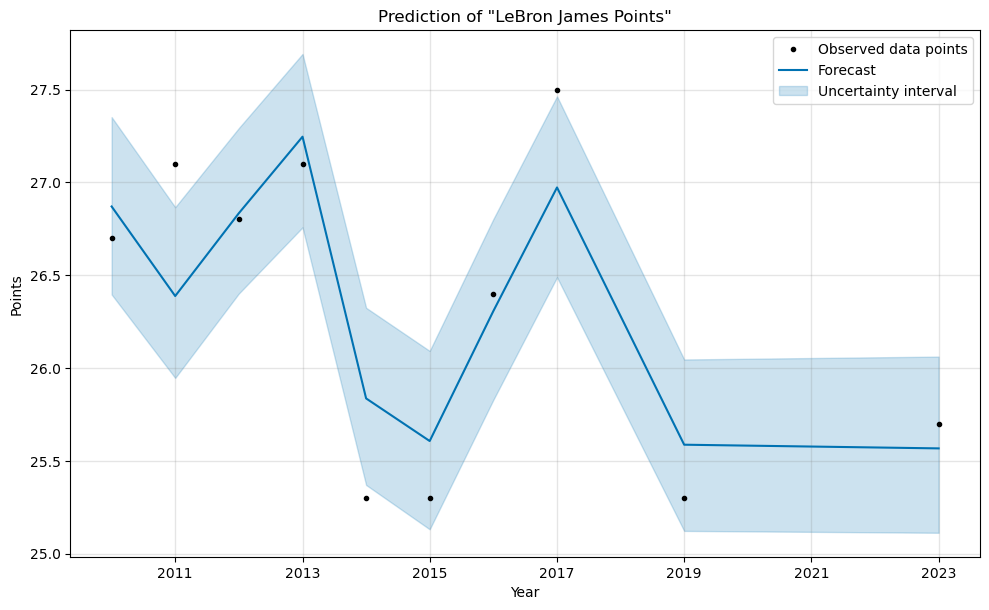

In [641]:
lbj_df.rename(columns={"Season": "ds", "PTS": "y"}, inplace=True)
Pts = fbProphet()
Pts.fit(lbj_df)
future = Pts.make_future_dataframe(periods=0, freq = 'Y')
forecast = Pts.predict(future)
fig = Pts.plot(forecast)
plt.legend()
plt.title('Prediction of "LeBron James Points"') 
plt.xlabel('Year')
plt.ylabel('Points')
plt.show()

Predicting missing values in Assist

22:06:32 - cmdstanpy - INFO - Chain [1] start processing
22:06:32 - cmdstanpy - INFO - Chain [1] done processing


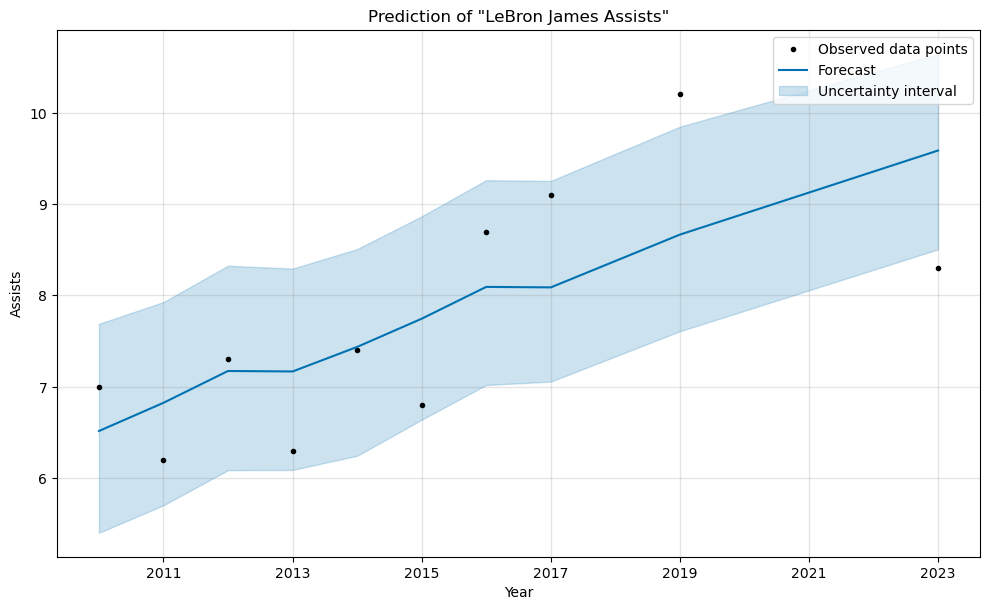

In [642]:
lbj_df.rename(columns={"y": "PTS", "AST": "y",}, inplace=True) 
Ast = fbProphet()
Ast.fit(lbj_df)
future = Ast.make_future_dataframe(periods=0, freq = 'Y')
forecast = Ast.predict(future)
fig = Ast.plot(forecast)
plt.legend()
plt.title('Prediction of "LeBron James Assists"')
plt.xlabel('Year')
plt.ylabel('Assists')
plt.show()

Predicting missing values for rebounds.

22:06:33 - cmdstanpy - INFO - Chain [1] start processing
22:06:33 - cmdstanpy - INFO - Chain [1] done processing


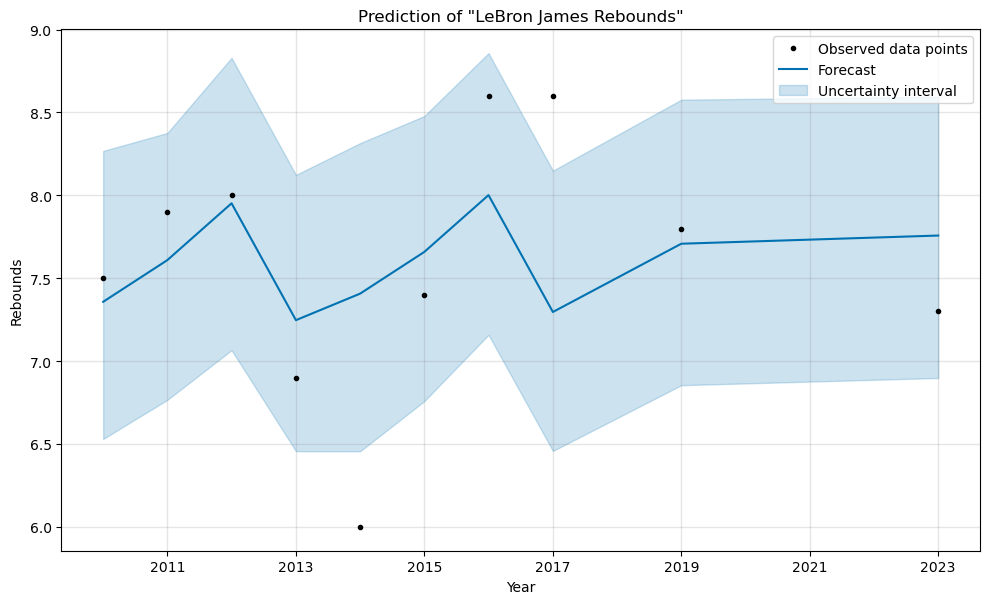

In [643]:
lbj_df.rename(columns={"y": "AST", "REB": "y",}, inplace=True)
Reb = fbProphet()
Reb.fit(lbj_df)
future = Reb.make_future_dataframe(periods=0, freq = 'Y')
forecast = Reb.predict(future)
fig = Reb.plot(forecast)
plt.legend()
plt.title('Prediction of "LeBron James Rebounds"')
plt.xlabel('Year')
plt.ylabel('Rebounds')
plt.show()

Predicting missing values for Games Played

22:06:33 - cmdstanpy - INFO - Chain [1] start processing
22:06:33 - cmdstanpy - INFO - Chain [1] done processing


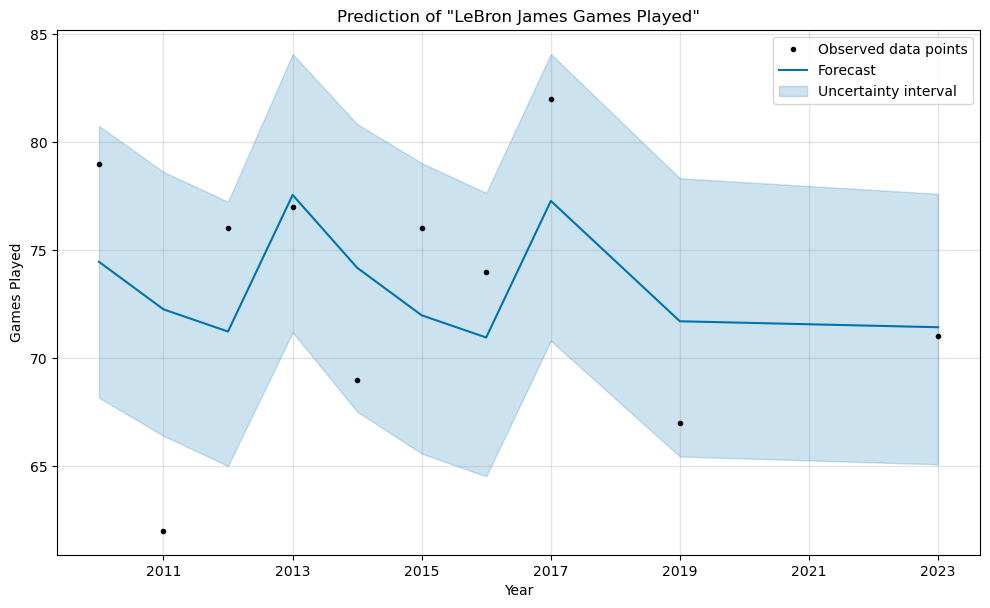

In [644]:
lbj_df.rename(columns={"y": "REB", "GP": "y",}, inplace=True)
GP = fbProphet()
GP.fit(lbj_df)
future = GP.make_future_dataframe(periods=0, freq = 'Y')
forecast = GP.predict(future)
fig = GP.plot(forecast)
plt.legend()
plt.title('Prediction of "LeBron James Games Played"')
plt.xlabel('Year')
plt.ylabel('Games Played')
plt.show()

Predicting missing values in minutes.

22:06:33 - cmdstanpy - INFO - Chain [1] start processing
22:06:33 - cmdstanpy - INFO - Chain [1] done processing


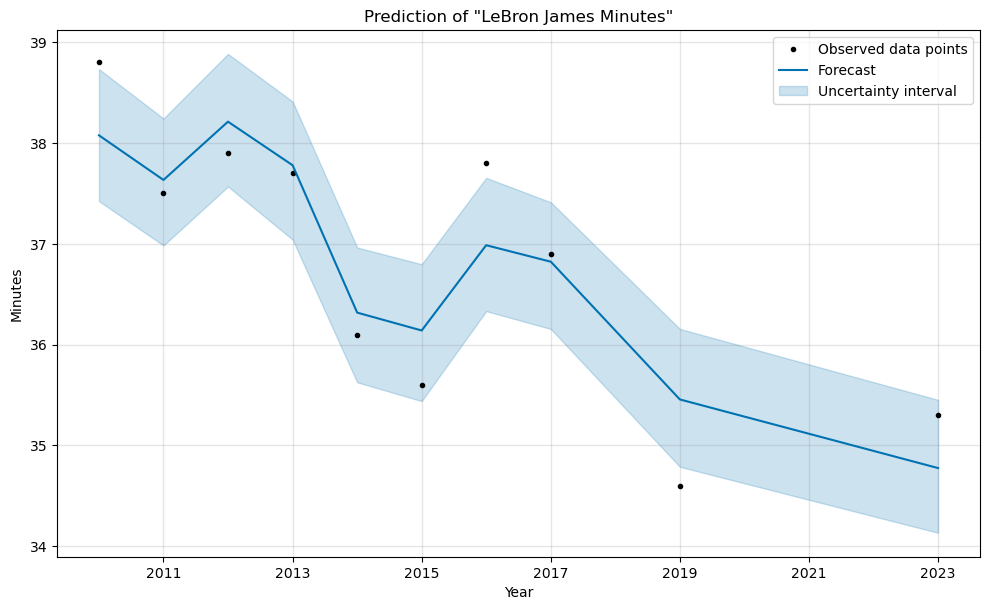

In [645]:
lbj_df.rename(columns={"y": "GP", "MIN": "y",}, inplace=True)
MIN = fbProphet()
MIN.fit(lbj_df)
future = MIN.make_future_dataframe(periods=0, freq = 'Y')
forecast = MIN.predict(future)
fig = MIN.plot(forecast)
plt.legend()
plt.title('Prediction of "LeBron James Minutes"')
plt.xlabel('Year')
plt.ylabel('Minutes')
plt.show()

Focusing on the 2018 season our model predicts that LeBrons stats were:

Points: 26.5

Assists: 8.5

Rebounds: 7.5

Games Played: 75

Minutes per game: 36.5

Comparing this to his actual stats in 2018 (from https://www.basketball-reference.com/players/j/jamesle01.html)

LeBron James actual 2018 stats:

Points: 27.4

Assists: 8.3

Rebounds: 8.5

Games Played: 82

Minutes Played: 36.9

By filling in the missing data, we aim to provide a complete and continuous record of LeBron James' performance metrics, which will be critical for further analysis and insights.

## Conclusion

The analysis of LeBron's performance across various seasons revealed his adaptability. Strategic workload management, a potential shift towards playmaking, and maintained efficiency highlighted his ability to evolve his game.

The model's predictions for LeBron's 2018 stats were remarkably close in key areas:

Points: Predicted (26.5) vs. Actual (27.4) - Difference of only 0.9 points.

Assists: Predicted (8.5) vs. Actual (8.3) - Difference of just 0.2 assists.

Rebounds: Predicted (7.5) vs. Actual (8.5) - Model slightly underestimated rebounding by 1 rebound.

Games played and minutes per game showed a slight discrepancy:

Games Played: Predicted (75) vs. Actual (82) - Model underestimated games played by 7 games.

Minutes Played: Predicted (36.5) vs. Actual (36.9) - A minor difference of 0.4 minutes.

Overall:

The model's performance in predicting LeBron James' 2018 statistics was impressive, particularly for points, assists, and rebounds. The slight underestimation of games played and minutes could be due to factors not accounted for in the model, such as specific team strategies or unexpected injuries. However, the close accuracy across other metrics highlights the model's potential for future predictions.

Future Considerations:

Expanding the model to incorporate additional data points, such as advanced metrics and playoff performance, could potentially improve prediction accuracy.
Analyzing the effectiveness of the model on other players with different playing styles could provide further insights into its generalizability.
LeBron James' remarkable adaptability showcased throughout his career, combined with the promising results of the model, suggest exciting possibilities for data-driven analysis in predicting player performance and understanding the ever-evolving landscape of basketball.